In [92]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The following allows to save plots in SVG format.
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [93]:
# Define the stock ticker symbol and the time period
symbol = 'ibm' # 'gs' 'nvda' 'tsla' 'msft' 'aapl' 'ibm'

def fetch_instrument_info(folder, symbol):
    path = folder + '/' + symbol + '.'

    instrument = yf.Ticker(symbol)
    info = pd.DataFrame.from_dict(instrument.info, orient="index")
    info.reset_index(inplace=True)
    info.columns = ["Attribute", "Recent"]
    info.to_csv(path + 'info.csv', index=False)
    
    actions = instrument.actions
    #print(actions)
    actions.to_csv(path + 'actions.csv', index=True)

    dividends = instrument.dividends
    dividends.to_csv(path + 'dividends.csv', index=True)

    splits = instrument.splits
    splits.to_csv(path + 'splits.csv', index=True)

    return actions

def adjust_instrument_history(path, unadjusted):
    adjusted = unadjusted.copy()
    adjusted['Ratio'] = adjusted['Adj Close'] / adjusted['Close']
    adjusted['Open'] = adjusted['Open'] * adjusted['Ratio']
    adjusted['High'] = adjusted['High'] * adjusted['Ratio']
    adjusted['Low'] = adjusted['Low'] * adjusted['Ratio']
    adjusted['Close'] = adjusted['Adj Close']
    adjusted['Volume'] = adjusted['Volume'] / adjusted['Ratio']
    adjusted.drop('Adj Close', axis=1, inplace=True)
    adjusted.drop('Ratio', axis=1, inplace=True)
    if 'Dividends' in adjusted.columns:
        adjusted.drop('Dividends', axis=1, inplace=True)
    if 'Stock Splits' in adjusted.columns:
        adjusted.drop('Stock Splits', axis=1, inplace=True)

    adjusted.to_csv(path, index=True)
    return adjusted

# interval: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d
def fetch_instrument_history(folder, symbol, interval='1d'):
    path = folder + '/' + symbol + '.' + interval + '.csv'
    path_adjusted = folder + '/' + symbol + '.' + interval + '.adjusted.csv'

    instrument = yf.Ticker(symbol)
    history = instrument.history(period='max', interval=interval, auto_adjust=False, actions=True, prepost=False)
    history.to_csv(path, index=True)

    start_date = history.index[0]
    end_date = history.index[-1]
    print('Symbol', symbol, 'from', start_date, 'to', end_date, 'interval', interval, 'saved to', path)

    adjusted = adjust_instrument_history(path_adjusted, history)
    return history, adjusted, start_date, end_date

def fetch_instrument_history_1d(folder, symbol):
    path = folder + '/' + symbol + '.1d.download.csv'
    path_adjusted = folder + '/' + symbol + '.1d.download.adjusted.csv'

    history = yf.download(symbol, progress=False)
    history.to_csv(path, index=True)

    start_date = history.index[0]
    end_date = history.index[-1]
    print('Symbol', symbol, 'from', start_date, 'to', end_date, 'interval', '1d', 'saved to', path)

    adjusted = adjust_instrument_history(path_adjusted, history)
    return history, adjusted, start_date, end_date

fetch_instrument_info('yfinance', symbol)
history, history_adjusted, start_date, end_date = \
    fetch_instrument_history('yfinance', symbol, interval='1d')
#history, history_adjusted, start_date1, end_date1 = \
#    fetch_instrument_history_1d('yfinance', symbol)


Symbol ibm from 1962-01-02 00:00:00-05:00 to 2024-05-17 00:00:00-04:00 interval 1d saved to yfinance/ibm.1d.csv


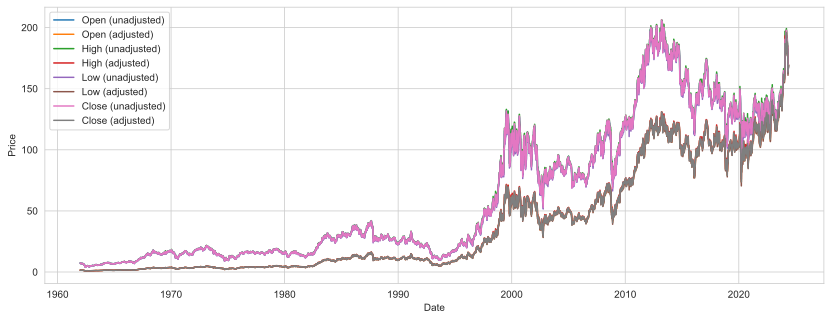

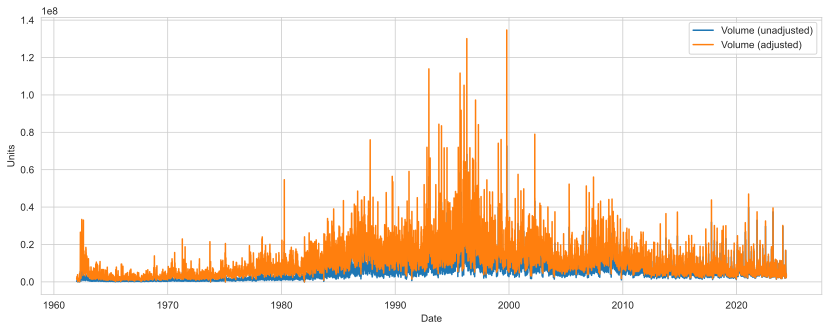

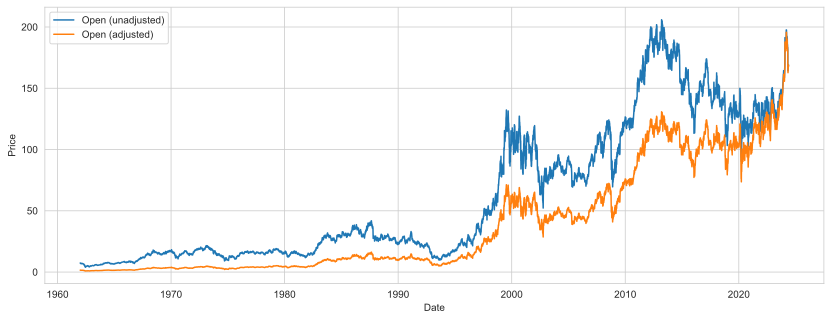

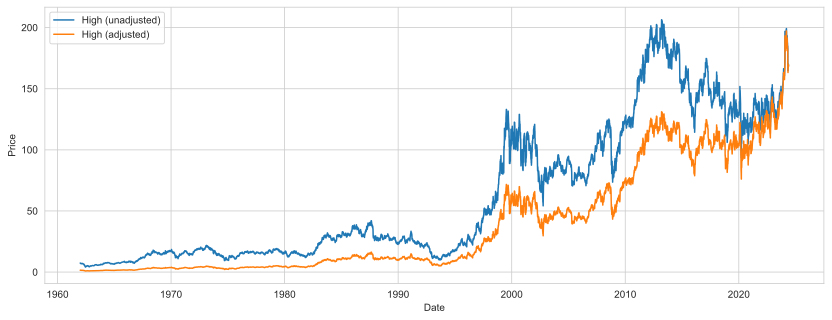

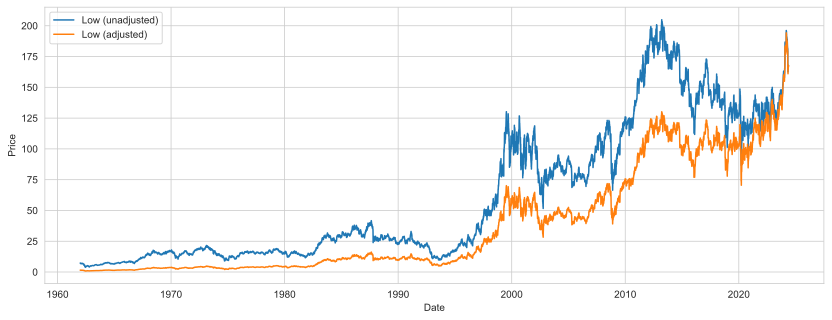

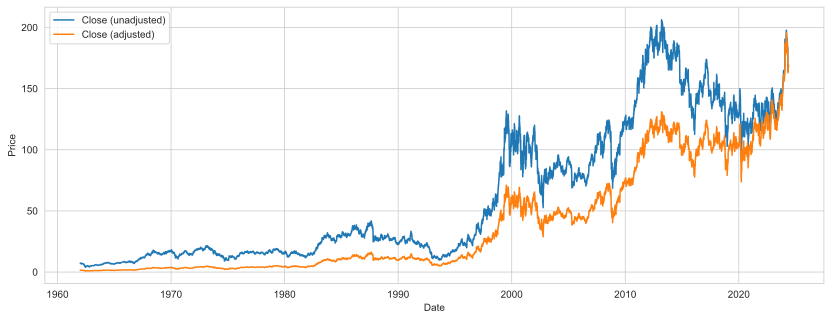

In [102]:
def plot_prices(history, history_adjusted, what_array, y_label='Price'):
    plt.figure(figsize=(14, 5))
    for what in what_array:
        plt.plot(history[what])
        plt.plot(history_adjusted[what])
    plt.xlabel('Date')
    plt.ylabel(y_label)
    legend = []
    for what in what_array:
        legend.append(what + ' (unadjusted)')
        legend.append(what + ' (adjusted)')
    plt.legend(legend, loc='best')
    plt.grid(True)
    plt.show()

plot_prices(history, history_adjusted, ['Open', 'High', 'Low', 'Close'])
plot_prices(history, history_adjusted, ['Volume'], y_label='Units')
plot_prices(history, history_adjusted, ['Open'])
plot_prices(history, history_adjusted, ['High'])
plot_prices(history, history_adjusted, ['Low'])
plot_prices(history, history_adjusted, ['Close'])

In [95]:
history_adjusted['Median'] = (history_adjusted['High'] + history_adjusted['Low']) / 2
history_adjusted['Typical'] = (history_adjusted['High'] + history_adjusted['Low'] + history_adjusted['Close']) / 3

history_adjusted['Open returns'] = history_adjusted['Open'].pct_change()
history_adjusted['High returns'] = history_adjusted['High'].pct_change()
history_adjusted['Low returns'] = history_adjusted['Low'].pct_change()
history_adjusted['Close returns'] = history_adjusted['Close'].pct_change()
history_adjusted['Median returns'] = history_adjusted['Median'].pct_change()
history_adjusted['Typical returns'] = history_adjusted['Typical'].pct_change()

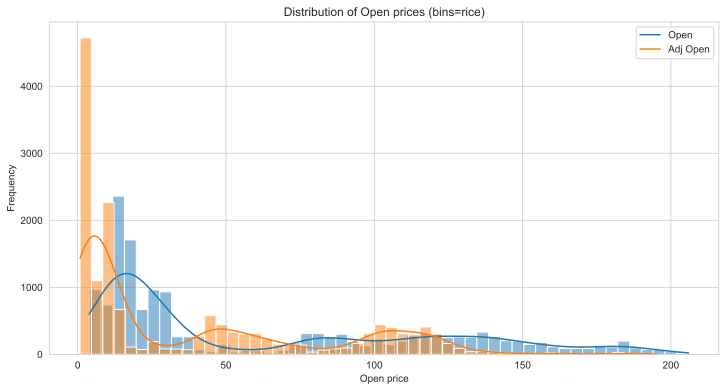

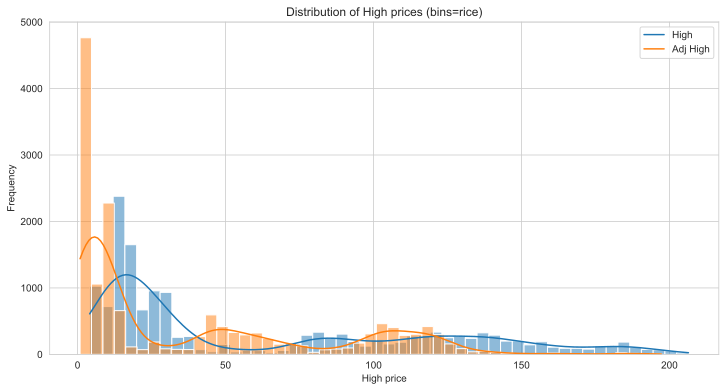

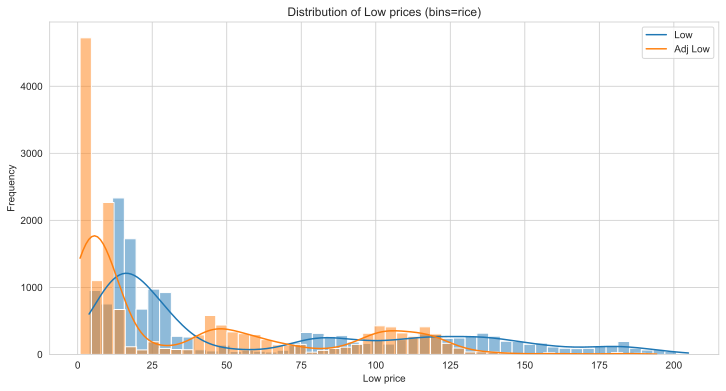

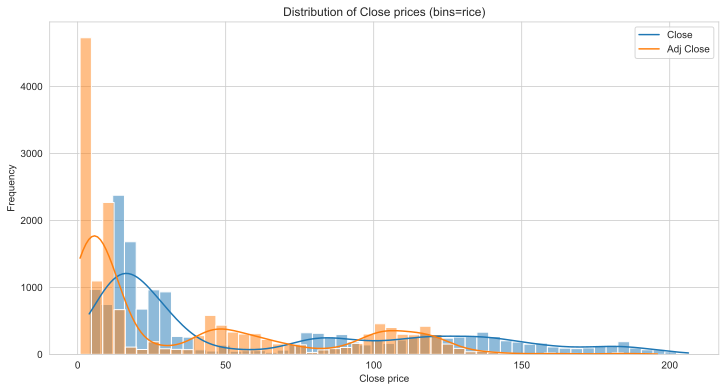

In [96]:
# Set the style of seaborn
sns.set_style('whitegrid')

# bins: integer or 'auto', 'scott', 'rice', 'sturges', 'sqrt'
def histogram_prices(history, history_adjusted, what, bins=50):
    plt.figure(figsize=(12, 6))
    sns.histplot(history[what], bins=bins, kde=True)
    sns.histplot(history_adjusted[what], bins=bins, kde=True)
    #plt.hist(history[what], bins=bins)
    #plt.hist(history_adjusted[what], bins=bins)
    plt.title('Distribution of ' + what + ' prices (bins=' + str(bins) + ')')
    plt.xlabel(what + ' price')
    plt.ylabel('Frequency')
    plt.legend([what, 'Adj ' + what], loc='best')
    plt.show()

histogram_prices(history, history_adjusted, 'Open', bins='rice')
histogram_prices(history, history_adjusted, 'High', bins='rice')
histogram_prices(history, history_adjusted, 'Low', bins='rice')
histogram_prices(history, history_adjusted, 'Close', bins='rice')

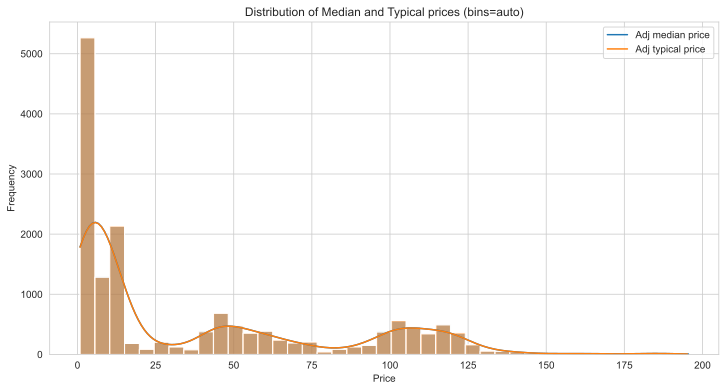

In [97]:
# Set the style of seaborn
sns.set_style('whitegrid')

# bins: integer or 'auto', 'scott', 'rice', 'sturges', 'sqrt'
bins = 'auto'
plt.figure(figsize=(12, 6))
sns.histplot(history_adjusted['Median'], bins=bins, kde=True)
sns.histplot(history_adjusted['Typical'], bins=bins, kde=True)
#plt.hist(history_adjusted['Median'], bins=bins)
#plt.hist(history_adjusted['Typical'], bins=bins)
plt.title('Distribution of Median and Typical prices (bins=' + str(bins) + ')')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(['Adj median price', 'Adj typical price'], loc='best')
plt.show()


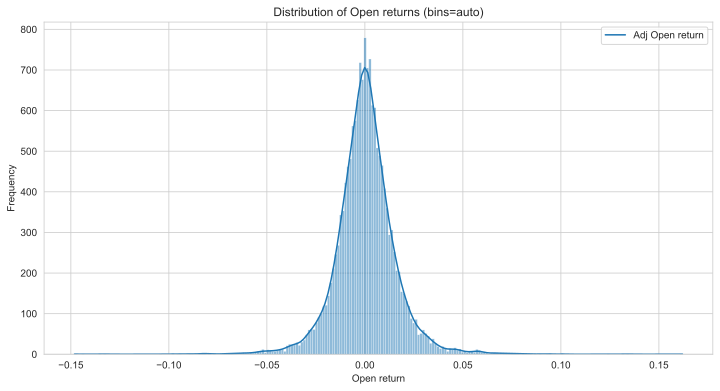

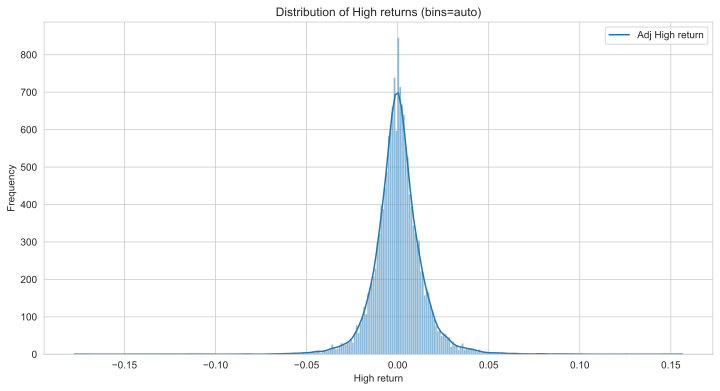

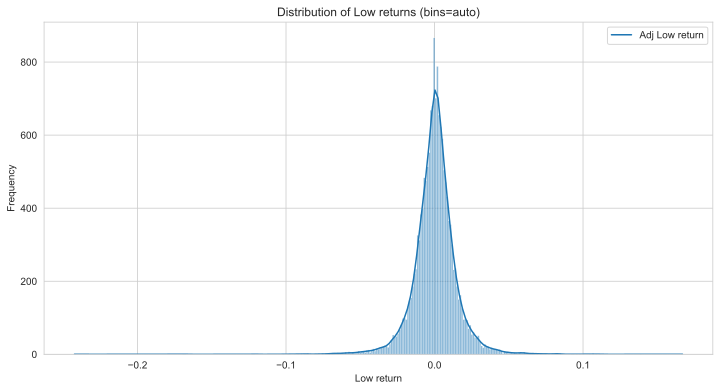

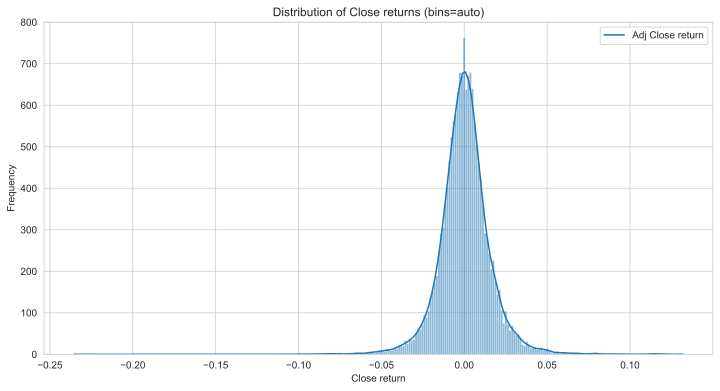

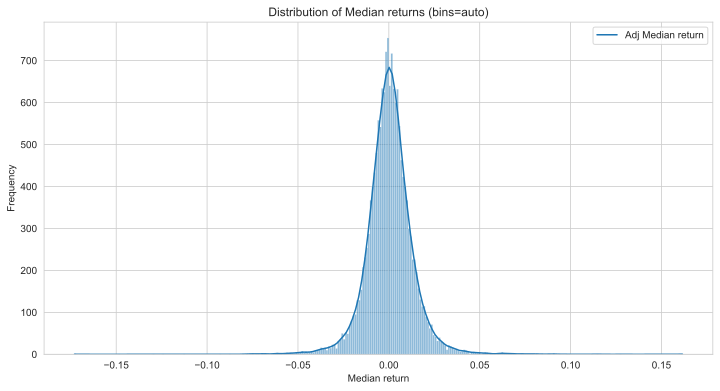

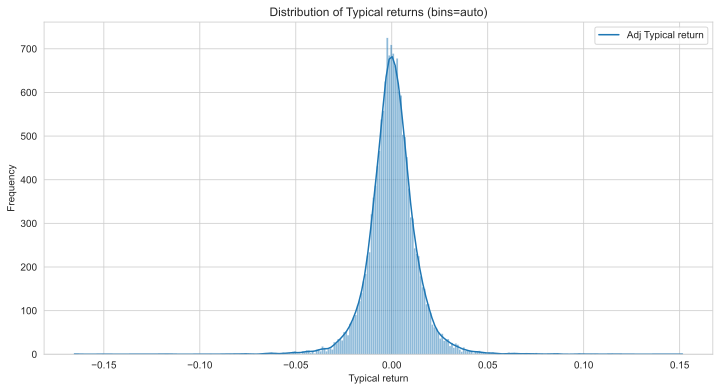

In [98]:
# Set the style of seaborn
sns.set_style('whitegrid')

# bins: integer or 'auto', 'scott', 'rice', 'sturges', 'sqrt'
def histogram_returns(history_adjusted, what, bins=50):
    plt.figure(figsize=(12, 6))
    sns.histplot(history_adjusted[what + ' returns'], bins=bins, kde=True)
    #plt.hist(history_adjusted[what + ' returns'], bins=bins)
    plt.title('Distribution of ' + what + ' returns (bins=' + str(bins) + ')')
    plt.xlabel(what + ' return')
    plt.ylabel('Frequency')
    plt.legend(['Adj ' + what + ' return'], loc='best')
    plt.show()

histogram_returns(history_adjusted, 'Open', bins='auto')
histogram_returns(history_adjusted, 'High', bins='auto')
histogram_returns(history_adjusted, 'Low', bins='auto')
histogram_returns(history_adjusted, 'Close', bins='auto')
histogram_returns(history_adjusted, 'Median', bins='auto')
histogram_returns(history_adjusted, 'Typical', bins='auto')

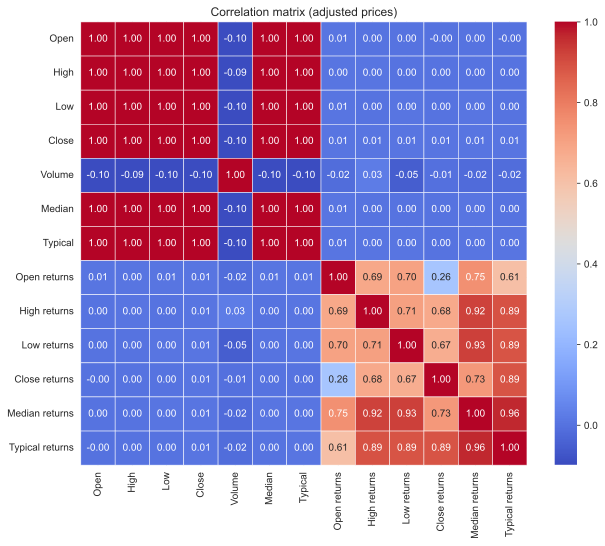

In [99]:
correlation_matrix = history_adjusted.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix (adjusted prices)')
plt.show()

In [100]:
print('-------------------------------- Unadjusted history')
history.info()
history.describe()

-------------------------------- Unadjusted history
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15702 entries, 1962-01-02 00:00:00-05:00 to 2024-05-17 00:00:00-04:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          15702 non-null  float64
 1   High          15702 non-null  float64
 2   Low           15702 non-null  float64
 3   Close         15702 non-null  float64
 4   Adj Close     15702 non-null  float64
 5   Volume        15702 non-null  int64  
 6   Dividends     15702 non-null  float64
 7   Stock Splits  15702 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.1 MB


Open          High           Low         Close     Adj Close  \
count  15702.000000  15702.000000  15702.000000  15702.000000  15702.000000   
mean      62.604807     63.180285     62.058665     62.624797     38.899087   
std       56.554011     57.010662     56.127272     56.579065     43.522565   
min        3.900574      4.098152      3.824092      3.900574      0.816895   
25%       15.632469     15.744503     15.512966     15.630975      4.131776   
50%       29.367830     29.576960     29.098948     29.367830     11.845206   
75%      112.913481    114.347517    111.589388    112.982794     64.649448   
max      205.908218    206.405350    204.875717    206.309753    195.835968   

             Volume     Dividends  Stock Splits  
count  1.570200e+04  15702.000000  15702.000000  
mean   5.086309e+06      0.006551      0.000958  
std    4.606864e+06      0.082114      0.046845  
min    0.000000e+00      0.000000      0.000000  
25%    1.539712e+06      0.000000      0.000000  
50%    4.301466e+06      0.000000      0.000000  
75%    7.036756e+06      0.000000      0.000000  
max    7.263916e+07      1.670000      4.000000

In [101]:
print('-------------------------------- Adjusted history')
history_adjusted.info()
history_adjusted.describe()

-------------------------------- Adjusted history
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15702 entries, 1962-01-02 00:00:00-05:00 to 2024-05-17 00:00:00-04:00
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             15702 non-null  float64
 1   High             15702 non-null  float64
 2   Low              15702 non-null  float64
 3   Close            15702 non-null  float64
 4   Volume           15702 non-null  float64
 5   Median           15702 non-null  float64
 6   Typical          15702 non-null  float64
 7   Open returns     15701 non-null  float64
 8   High returns     15701 non-null  float64
 9   Low returns      15701 non-null  float64
 10  Close returns    15701 non-null  float64
 11  Median returns   15701 non-null  float64
 12  Typical returns  15701 non-null  float64
dtypes: float64(13)
memory usage: 1.7 MB


Open          High           Low         Close        Volume  \
count  15702.000000  15702.000000  15702.000000  15702.000000  1.570200e+04   
mean      38.886109     39.238091     38.551910     38.899087  1.035587e+07   
std       43.507398     43.849850     43.181263     43.522565  8.603553e+06   
min        0.816894      0.858274      0.800877      0.816895  0.000000e+00   
25%        4.130939      4.153909      4.103840      4.131776  4.408099e+06   
50%       11.847319     11.952399     11.752054     11.845206  8.128536e+06   
75%       64.649469     65.466778     63.961023     64.649448  1.395514e+07   
max      195.637925    197.222201    194.212077    195.835968  1.347071e+08   

             Median       Typical  Open returns  High returns   Low returns  \
count  15702.000000  15702.000000  1.570100e+04  15701.000000  15701.000000   
mean      38.895000     38.896363  4.191757e-04      0.000394      0.000409   
std       43.514616     43.516929  1.549743e-02      0.013813      0.014804   
min        0.843257      0.834470 -1.481482e-01     -0.177446     -0.242424   
25%        4.132075      4.131155 -7.495284e-03     -0.006307     -0.006508   
50%       11.846465     11.844264  2.881062e-07      0.000000      0.000484   
75%       64.699562     64.719349  8.094835e-03      0.006680      0.007313   
max      195.494346    195.198944  1.620031e-01      0.156364      0.166919   

       Close returns  Median returns  Typical returns  
count   15701.000000    15701.000000     15701.000000  
mean        0.000425        0.000386         0.000386  
std         0.015840        0.013211         0.013154  
min        -0.235185       -0.172962        -0.165297  
25%        -0.007677       -0.006272        -0.006047  
50%         0.000000        0.000273         0.000265  
75%         0.008152        0.006875         0.006771  
max         0.131637        0.161536         0.151437